In [1]:
from utils import config, parse_midas_data, sample_utils as su, temporal_changes_utils
from collections import defaultdict
import numpy as np
import pickle
import sys
from matplotlib import pyplot as plt
import random

# Cohort list
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm', 'hmp']

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

# SNP change pickle
species_snp_changes = pickle.load(open('%s/pickles/species_snp_changes_full.pkl' % config.data_directory))
snp_change_counts = pickle.load(open('%s/pickles/sample_snp_change_counts_mod20.pkl' % config.data_directory, 'rb'))
# replacements = pickle.load(open('%s/pickles/sample_replacements.pkl' % config.data_directory, 'rb'))
snp_changes = pickle.load(open('%s/pickles/big_snp_changes_full.pkl' % config.data_directory, 'rb'))

In [2]:
# Sample-subject-order maps
sys.stderr.write("Loading sample metadata...\n")
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
sample_subject_map = su.parse_sample_subject_map()
sys.stderr.write("Done!\n")

# Timepoint pair types
tp_pair_names = ['MM', 'MI', 'II', 'AA']

# Cohorts
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm', 'hmp']
mi_cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm']

# Samples for each cohort
samples = {cohort: su.get_sample_names(cohort) for cohort in cohorts}
hmp_samples = su.get_sample_names('hmp')
mother_samples = su.get_sample_names('mother')
infant_samples = su.get_sample_names('infant')
olm_samples = su.get_sample_names('olm')

# Sample-cohort map
sample_cohort_map = su.parse_sample_cohort_map()

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

Loading sample metadata...
Done!


In [3]:
from utils import sample_utils as su, parse_midas_data, substitution_rates_utils, config, temporal_changes_utils, snps_utils
import numpy as np
from numpy.random import choice
from collections import defaultdict
import pickle
import sys

# ======================================================
# Examines all nonconsecutive timepoint pairs within hosts
# across all cohorts, and pickles information about
# SNP and gene changes
# ======================================================

# Parameters
sweep_type = 'full'
upper_threshold = 0.2
lower_threshold = 0.8

min_sample_size = 3
variant_types = ['1D','4D']
within_host_type = 'consecutive' # consecutive timepoints
min_snp_change_sample_size = 5

# Sample pair SNP change count dict
snp_change_counts = defaultdict(dict)

# Species-sample pair replacement dict (1 or 0)
replacements = defaultdict(dict)

for species_name in good_species_list[::-1]:
	
	sys.stderr.write("\nProcessing %s...\n" % species_name)
	
	# Grab QP samples for this species
	qp_sample_lists = {}
	for cohort in cohorts:
		qp_sample_lists[cohort] = sorted(su.load_qp_samples(samples[cohort], species_name)['qp'])
	
	combined_qp_samples = sorted(su.flatten([qp_sample_lists[cohort] for cohort in cohorts]))
	combined_sample_idx_map = {combined_qp_samples[i] : i for i in range(len(combined_qp_samples))}
	
	# Using all QP samples to threshold on sample size
	if len(combined_qp_samples) < min_sample_size:
		sys.stderr.write("Not enough haploid samples!\n")
		continue
	
	# Load substitution rates for all QP samples
	sys.stderr.write("Loading pre-computed substitution rates for %s...\n" % species_name)
	substitution_rate_map = substitution_rates_utils.load_substitution_rate_map(species_name)
	
	if substitution_rate_map == {}: # Not enough haploid samples
		sys.stderr.write("Not enough haploid samples!\n")
		continue
	
	sys.stderr.write("Calculating SNV matrix...\n")
	dummy_samples, snp_mut_difference_matrix, snp_rev_difference_matrix, snp_mut_opportunity_matrix, snp_rev_opportunity_matrix = substitution_rates_utils.calculate_mutrev_matrices_from_substitution_rate_map(substitution_rate_map, 'all', allowed_samples=combined_qp_samples)
	
	snp_difference_matrix = snp_mut_difference_matrix + snp_rev_difference_matrix
	snp_opportunity_matrix = snp_mut_opportunity_matrix+snp_rev_opportunity_matrix
	snp_substitution_rate = snp_difference_matrix*1.0/(snp_opportunity_matrix+(snp_opportunity_matrix==0))
	sys.stderr.write("Done!\n")
	
	sys.stderr.write("Loading gene matrix...\n")
	gene_samples, gene_loss_difference_matrix, gene_gain_difference_matrix, gene_loss_opportunity_matrix, gene_gain_opportunity_matrix = substitution_rates_utils.calculate_mutrev_matrices_from_substitution_rate_map(substitution_rate_map, 'genes', allowed_samples=combined_qp_samples)
	gene_difference_matrix = gene_gain_difference_matrix + gene_loss_difference_matrix
	gene_opportunity_matrix = gene_loss_opportunity_matrix
	gene_difference_matrices = {'gains': gene_gain_difference_matrix, 'losses': gene_loss_difference_matrix}
	sys.stderr.write("Done!\n")
	
	sys.stderr.write("Loading 1D & 4D opportunity matrices...\n")	
	difference_matrices, opportunity_matrices = {}, {}	
	for var_type in variant_types:		
		matrix_samples, difference_matrix, opportunity_matrix = substitution_rates_utils.calculate_matrices_from_substitution_rate_map(substitution_rate_map, var_type, allowed_samples=combined_qp_samples)		
		difference_matrices[var_type] = difference_matrix
		opportunity_matrices[var_type] = opportunity_matrix
	
	sys.stderr.write("Done!\n")
	
	# Load temporal change map
	sys.stderr.write("Loading pre-computed temporal changes...\n")
	temporal_change_map = temporal_changes_utils.load_temporal_change_map(species_name) # Default min coverage 20
	sys.stderr.write("Done!\n")
	
	# Loop over different cohorts
	for cohort in cohorts:		
		desired_samples = qp_sample_lists[cohort]
		
		same_subject_idxs = su.calculate_mi_ordered_same_subject_pairs(sample_order_map, desired_samples, within_host_type=within_host_type, one_per_mi_pair=False)
		
		# Loop over different pairs of within-host samples
		for sample_pair_idx in range(len(same_subject_idxs[0])):			 
				
				sample_i = desired_samples[same_subject_idxs[0][sample_pair_idx]] 
				sample_j = desired_samples[same_subject_idxs[1][sample_pair_idx]]
				tp_pair = su.sample_pair_to_tp_pair(sample_i, sample_j, sample_order_map, hmp_samples, mother_samples)
				
				i = combined_sample_idx_map[sample_i]
				j = combined_sample_idx_map[sample_j]
				
				# Checks if among those samples from different hosts,
				# at least one of them has nonzero SNP and gene opportunities
				good_idxs = su.calculate_samples_in_different_subjects(sample_subject_map, combined_qp_samples, sample_i)
				good_idxs *= ( (snp_opportunity_matrix[i,:]>0.5) * (gene_opportunity_matrix[i,:]>0.5) )
				
				if good_idxs.sum() < 1:
					sys.stderr.write("Not enough other-host samples!\n")
					continue
				
				matrix_idx_i = matrix_samples.index(sample_i)
				matrix_idx_j = matrix_samples.index(sample_j)
				
				# Numbers of site differences and opportunities between the timepoints
				nonsyn_diffs = difference_matrices['1D'][matrix_idx_i][matrix_idx_j]
				nonsyn_opps = opportunity_matrices['1D'][matrix_idx_i][matrix_idx_j]		
				syn_diffs = difference_matrices['4D'][matrix_idx_i][matrix_idx_j]
				syn_opps = opportunity_matrices['4D'][matrix_idx_i][matrix_idx_j]
				
				# SNP temporal changes
				L, perr, mutations, reversions = temporal_changes_utils.calculate_mutations_reversions_from_temporal_change_map(temporal_change_map, sample_i, sample_j, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
				
				if L<config.min_opportunities:
					sys.stderr.write("Not enough SNP opportunities (should be >=100,000)!\n")
					continue
				
				nerr = L*perr
				
				num_mutations = len(mutations)
				num_reversions = len(reversions)
				num_snp_changes = num_mutations + num_reversions
				
				if num_snp_changes < 20:
					snp_change_counts[(sample_i, sample_j)][species_name] = num_snp_changes
				if num_snp_changes > 400:
					replacements[(sample_i, sample_j)][species_name] = num_snp_changes  


Processing Peptoniphilus_rhinitidis_62391...
Loading pre-computed substitution rates for Peptoniphilus_rhinitidis_62391...
Not enough haploid samples!

Processing Actinomyces_sp_62581...
Not enough haploid samples!

Processing Clostridium_sordellii_57678...
Loading pre-computed substitution rates for Clostridium_sordellii_57678...
Not enough haploid samples!

Processing Eubacterium_biforme_61684...
Loading pre-computed substitution rates for Eubacterium_biforme_61684...
Calculating SNV matrix...
Done!
Loading gene matrix...
Done!
Loading 1D & 4D opportunity matrices...
Done!
Loading pre-computed temporal changes...
Done!

Processing Clostridium_baratii_60475...
Loading pre-computed substitution rates for Clostridium_baratii_60475...
Not enough haploid samples!

Processing Finegoldia_magna_57293...
Loading pre-computed substitution rates for Finegoldia_magna_57293...
Not enough haploid samples!

Processing Lactobacillus_crispatus_56887...
Loading pre-computed substitution rates for Lac

In [46]:
pickle.dump(snp_change_counts, open('%s/pickles/sample_species_snp_change_counts_mod20_cons.pkl' % config.data_directory, 'wb'))
pickle.dump(replacements, open('%s/pickles/sample_species_replacements_400_cons.pkl' % config.data_directory, 'wb'))

In [3]:
# Calculate number of days for a timpeoint pair

mi_sample_day_dict = su.get_mi_sample_day_dict()

def sample_pair_to_days(sample1, sample2):
    days = mi_sample_day_dict[sample2] - mi_sample_day_dict[sample1]
    if days < 0:
        return np.abs(days)
    return days

def tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    o1 = float(tpa[1:])
    o2 = float(tpb[1:])
    return np.abs(o1-o2)

# Rough approximation of HMP time intervals
def adult_tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    return np.abs(int(tpa[-1:]) - int(tpb[-1:]))*183

def tp_pair_to_tp_type(tp_pair):
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type == 'IM':
        tp_type = 'MI'
    return tp_type

In [4]:
# Overview of replacement info

infant_tp_type_dict = {'Day 0-Week 1': (0, 7), 'Week 1-Month 1': (7,31), 'Month 1-Month 4': (31,122), 'Month 1-Year 1': (31, 365)}
replacement_time_tups_by_infant_tp_type = defaultdict(list)
replacement_time_tups_by_tp_type = defaultdict(list)
all_time_tups_by_infant_tp_type = defaultdict(list)
all_time_tups_by_tp_type = defaultdict(list)

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        if s1 in olm_samples:
            continue
        
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tpa, tpb = tp_pair
        tp_type = tp_pair_to_tp_type(tp_pair)            
        days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
        
        # Condition MI on comparing to infants in first week
        if tp_type == 'MI':
            if s2 in infant_samples and mi_sample_day_dict[s2] > 7:
                continue
            if s1 in infant_samples and mi_sample_day_dict[s1] > 7:
                continue
        
        val = snp_changes[species][(s1, s2)]
        
        if isinstance(val, int): # replacement
            replacement_time_tups_by_tp_type[tp_type].append((1, days))
            all_time_tups_by_tp_type[tp_type].append((val, days))
        else: # not replacement
            all_time_tups_by_tp_type[tp_type].append((len(val), days))            
        
        if tp_type == 'II':
            day1, day2 = mi_sample_day_dict[s1], mi_sample_day_dict[s2]
            for infant_tp_type in infant_tp_type_dict:
                start, end = infant_tp_type_dict[infant_tp_type]
                if day1 >= start and day2 <= end:            
                    days = np.abs(day1 - day2)
                    if isinstance(val, int):
                        replacement_time_tups_by_infant_tp_type[infant_tp_type].append((1, days))
                        all_time_tups_by_infant_tp_type[infant_tp_type].append((val, days))
                    else:
                        all_time_tups_by_infant_tp_type[infant_tp_type].append((len(val), days))

In [5]:
bootstrapped_replacement_rates_by_tp_type = defaultdict(list)
bootstrapped_replacement_rates_by_infant_tp_type = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in replacement_time_tups_by_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = replacement_time_tups_by_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_days = 0
        for num_replacements, days in bootstrap:
            total_replacements += num_replacements
            total_days += days
        bootstrapped_replacement_rates_by_tp_type[tp_type].append(float(total_replacements/float(len(bootstrap)))/total_days)

for tp_type in replacement_time_tups_by_infant_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = replacement_time_tups_by_infant_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_days = 0
        for num_replacements, days in bootstrap:
            total_replacements += num_replacements
            total_days += days
        bootstrapped_replacement_rates_by_infant_tp_type[tp_type].append(float(total_replacements/float(len(bootstrap)))/total_days)

In [6]:
for tp_type in all_time_tups_by_tp_type:
    print(len(all_time_tups_by_tp_type[tp_type]))

1383
1014
69
67


Day 0-Week 1
10
36
Week 1-Month 1
11
154
Month 1-Year 1
2
62
MI
5
10
MM
4
460
AA
26
5307


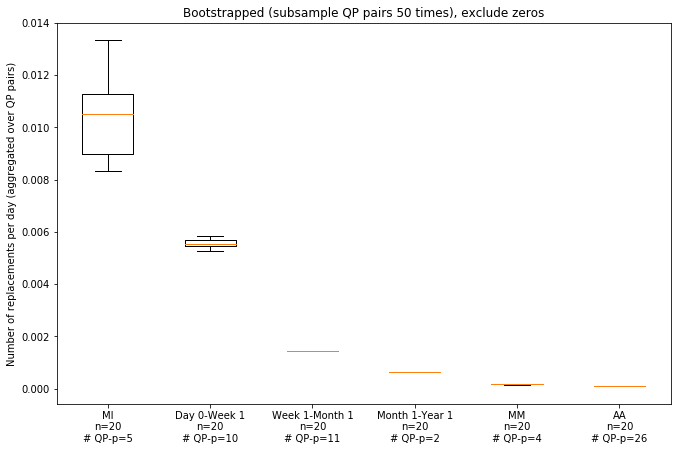

In [7]:
fig, ax = plt.subplots(figsize=(11,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_replacement_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    replacement_count, total_days = (0,0)
    for count, days in replacement_time_tups_by_infant_tp_type[infant_tp_type]:
        replacement_count += count
        total_days += days
    print(infant_tp_type)
    print(replacement_count)
    print(total_days)
    annotations.append(float(replacement_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, len(bootstrapped_replacement_rates_by_infant_tp_type[infant_tp_type]), len(replacement_time_tups_by_infant_tp_type[infant_tp_type])))

bootstrapped_rates = [bootstrapped_replacement_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    replacement_count, total_days = (0,0)
    for count, days in replacement_time_tups_by_tp_type[tp_type]:
        replacement_count += count
        total_days += days
    print(tp_type)
    print(replacement_count)
    print(total_days)
    annotations.append(float(replacement_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_replacement_rates_by_tp_type[tp_type]), len(replacement_time_tups_by_tp_type[tp_type])))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

# ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered)
ax.set_ylabel("Number of replacements per day (aggregated over QP pairs)")
ax.set_title("Bootstrapped (subsample QP pairs 50 times), exclude zeros")

plt.show()

# fig.savefig('%s/snp_change_rates_by_tp_type_overall_no_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [17]:
# This measures the proportion of QP pairs that are replacements
# rather than how long, on average, replacements take

bootstrapped_replacement_rates_alt_by_tp_type = defaultdict(list)
bootstrapped_replacement_rates_alt_by_infant_tp_type = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in all_time_tups_by_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = all_time_tups_by_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_qp_pairs = 0
        for num_snp_changes, days in bootstrap:
            if num_snp_changes >= 500:
                total_replacements += 1
            total_qp_pairs += 1
        bootstrapped_replacement_rates_alt_by_tp_type[tp_type].append(float(total_replacements)/total_qp_pairs)

for tp_type in all_time_tups_by_infant_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = all_time_tups_by_infant_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_qp_pairs = 0
        for num_snp_changes, days in bootstrap:
            if num_snp_changes >= 500:
                total_replacements += 1
            total_qp_pairs += 1
        bootstrapped_replacement_rates_alt_by_infant_tp_type[tp_type].append(float(total_replacements)/total_qp_pairs)

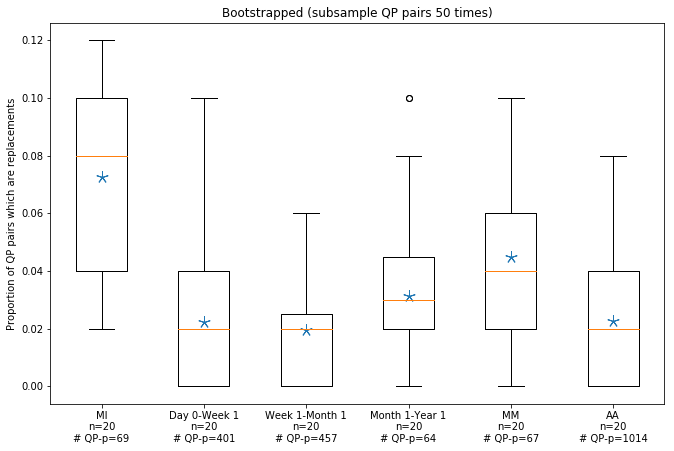

In [18]:
fig, ax = plt.subplots(figsize=(11,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_replacement_rates_alt_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    replacement_count, total_count = (0,0)
    for num_snp_changes, days in all_time_tups_by_infant_tp_type[infant_tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_count += 1
    annotations.append(float(replacement_count)/total_count)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, len(bootstrapped_replacement_rates_alt_by_infant_tp_type[infant_tp_type]), len(all_time_tups_by_infant_tp_type[infant_tp_type])))

bootstrapped_rates = [bootstrapped_replacement_rates_alt_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    replacement_count, total_count = (0,0)
    for num_snp_changes, days in all_time_tups_by_tp_type[tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_count += 1
    annotations.append(float(replacement_count)/total_count)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_replacement_rates_alt_by_tp_type[tp_type]), len(all_time_tups_by_tp_type[tp_type])))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered)
ax.set_ylabel("Proportion of QP pairs which are replacements")
ax.set_title("Bootstrapped (subsample QP pairs 50 times)")

plt.show()

# fig.savefig('%s/snp_change_rates_by_tp_type_overall_no_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [11]:
# Finally, get sense of how many replacements occur
# per unit time [in a host]
# HEY: reusing variable names so be careful!

bootstrapped_replacement_rates_alt_by_tp_type = defaultdict(list)
bootstrapped_replacement_rates_alt_by_infant_tp_type = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in all_time_tups_by_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = all_time_tups_by_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_days = 0
        for num_snp_changes, days in bootstrap:
            if num_snp_changes >= 500:
                total_replacements += 1
            total_days += days
        bootstrapped_replacement_rates_alt_by_tp_type[tp_type].append(float(total_replacements)/total_days)

for tp_type in all_time_tups_by_infant_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = all_time_tups_by_infant_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_replacements = 0
        total_days = 0
        for num_snp_changes, days in bootstrap:
            if num_snp_changes >= 500:
                total_replacements += 1
            total_days += days
        bootstrapped_replacement_rates_alt_by_infant_tp_type[tp_type].append(float(total_replacements)/total_days)

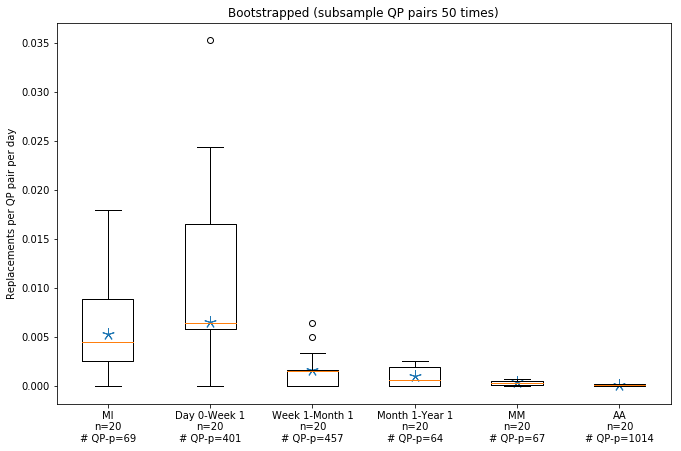

In [13]:
fig, ax = plt.subplots(figsize=(11,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_replacement_rates_alt_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    replacement_count, total_days = (0,0)
    for num_snp_changes, days in all_time_tups_by_infant_tp_type[infant_tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_days += days
    annotations.append(float(replacement_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, len(bootstrapped_replacement_rates_alt_by_infant_tp_type[infant_tp_type]), len(all_time_tups_by_infant_tp_type[infant_tp_type])))

bootstrapped_rates = [bootstrapped_replacement_rates_alt_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    replacement_count, total_days = (0,0)
    for num_snp_changes, days in all_time_tups_by_tp_type[tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_days += days
    annotations.append(float(replacement_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_replacement_rates_alt_by_tp_type[tp_type]), len(all_time_tups_by_tp_type[tp_type])))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered)
ax.set_ylabel("Replacements per QP pair per day")
ax.set_title("Bootstrapped (subsample QP pairs 50 times)")

plt.show()

# fig.savefig('%s/snp_change_rates_by_tp_type_overall_no_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [15]:
# idea: make colored scatterplot where one axis is
# duration of qp pair, other axis is initial time,
# and color accoridng to number of SNPs

num_snps = []
init_times = []
durations = []

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        if s1 in olm_samples:
            continue
        
        tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
        tpa, tpb = tp_pair
        tp_type = tp_pair_to_tp_type(tp_pair)
        if tp_type != 'II':
            continue
        days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
        day1 = mi_sample_day_dict[s1]
        
        val = snp_changes[species][(s1, s2)]
        
        if isinstance(val, int): # replacement
            num_snps.append(val)
        else: # not replacement
            num_snps.append(len(val))
        
        init_times.append(day1)
        durations.append(days)        

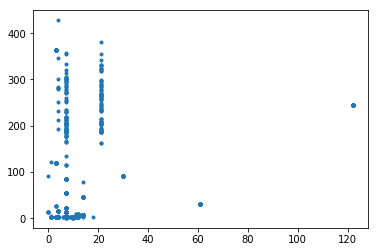

In [18]:
plt.plot(init_times, durations, '.')
plt.show()

frozenset(['I1', 'M2'])
0
0
frozenset(['I1', 'M2'])
0
0


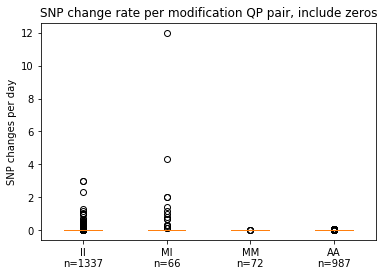

In [57]:
fig, ax = plt.subplots(figsize=(6,4))

rates_by_tp_type = defaultdict(list)
count_time_tups_by_tp_type = defaultdict(list)
replacement_time_tups_by_tp_type = defaultdict(list)
agg_snp_change_counts = defaultdict(int)
agg_snp_change_time = defaultdict(float)

tp_type_cohort_comp = defaultdict(list)

for s1, s2 in snp_change_counts:            
    
    if s1 in olm_samples:
        continue
    
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type == 'IM':
        tp_type = 'MI'

    if tp_type in ['AA']:
        days = adult_tp_pair_to_days(tp_pair)
    else:
        days = sample_pair_to_days(s1, s2)
    
    # Condition MI on comparing to infants in first week
    if tp_type == 'MI':
        if s2 in infant_samples and mi_sample_day_dict[s2] > 7:
            # print(mi_sample_day_dict[s2])
            continue
        if s1 in infant_samples and mi_sample_day_dict[s1] > 7:
            # print(mi_sample_day_dict[s1])
            continue
    
    if days == 0:
        print(tp_pair)
        print(mi_sample_day_dict[s1])
        print(mi_sample_day_dict[s2])
        if mi_sample_day_dict[s1] == 0:
            days = 1
        else:
            continue
    
    for species in snp_change_counts[(s1, s2)]:
        num_sweeps = snp_change_counts[(s1, s2)][species]
        tp_type_cohort_comp[tp_type].append(sample_cohort_map[s1])    
        if exclude_zeros:
            if num_sweeps > 0:
                rates_by_tp_type[tp_type].append(float(num_sweeps)/days)
        else:
            rates_by_tp_type[tp_type].append(float(num_sweeps)/days)
        count_time_tups_by_tp_type[tp_type].append((num_sweeps, days))
        agg_snp_change_counts[tp_type] += num_sweeps
        agg_snp_change_time[tp_type] += days

for s1, s2 in replacements:            
    
    if s1 in olm_samples:
        continue
    
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type == 'IM':
        tp_type = 'MI'

    if tp_type in ['AA']:
        days = adult_tp_pair_to_days(tp_pair)
    else:
        days = sample_pair_to_days(s1, s2)
    
    # Condition MI on comparing to infants in first week
    if tp_type == 'MI':
        if s2 in infant_samples and mi_sample_day_dict[s2] > 7:
            # print(mi_sample_day_dict[s2])
            continue
        if s1 in infant_samples and mi_sample_day_dict[s1] > 7:
            # print(mi_sample_day_dict[s1])
            continue
    
    if days == 0:
        if mi_sample_day_dict[s1] == 0:
            days = 1
        else:
            continue
    
    for species in replacements[(s1, s2)]:
        num_snp_diffs = replacements[(s1, s2)][species]
        replacement_time_tups_by_tp_type[tp_type].append((num_snp_diffs, days))

tp_types = ['II', 'MI', 'MM', 'AA']
tp_type_labels = []

rates = [rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    tp_type_labels.append('%s\nn=%i' % (tp_type, len(rates_by_tp_type[tp_type])))

# ax.set_yscale('log')
ax.boxplot(rates)
ax.set_xticklabels(tp_type_labels)
ax.set_title("SNP change rate per modification QP pair, include zeros")
ax.set_ylabel("SNP changes per day")

plt.show()

fig.savefig('%s/snp_change_rates_with_zeros.pdf' % plot_dir, bbox_inches='tight')

In [9]:
def summarize_bag(bag):
    item_count_dict = defaultdict(int)
    for item in bag:
        item_count_dict[item] += 1
    for item in item_count_dict:
        print('%s: %i' % (item, item_count_dict[item]))

In [10]:
for tp_type in tp_type_cohort_comp:
    print(tp_type)
    summarize_bag(tp_type_cohort_comp[tp_type])

AA
hmp: 987
II
yassour: 195
ferretti: 44
shao: 937
backhed: 161
MI
yassour: 15
ferretti: 4
shao: 24
backhed: 23
MM
yassour: 72


In [11]:
agg_snp_change_counts

defaultdict(int, {'AA': 835, 'II': 678, 'MI': 73, 'MM': 36})

In [12]:
agg_snp_change_time

defaultdict(float, {'AA': 191967.0, 'II': 77584.0, 'MI': 925.0, 'MM': 8004.0})

In [13]:
for tp_type in agg_snp_change_time:
    print(tp_type)
    print(float(agg_snp_change_counts[tp_type])/agg_snp_change_time[tp_type])

AA
0.00434970593904
II
0.00873891524026
MI
0.0789189189189
MM
0.00449775112444


In [14]:
for tp_type in rates_by_tp_type:
    print(tp_type)
    print(np.mean(rates_by_tp_type[tp_type]))

AA
0.004373799281368169
II
0.027273318865695187
MI
0.41744902216885477
MM
0.004906400966183575


In [15]:
bootstrapped_rates_by_tp_type = defaultdict(list)
bootstrapped_rates_by_tp_type_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type[tp_type].append(float(total_sweeps)/total_days)
        bootstrapped_rates_by_tp_type_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)

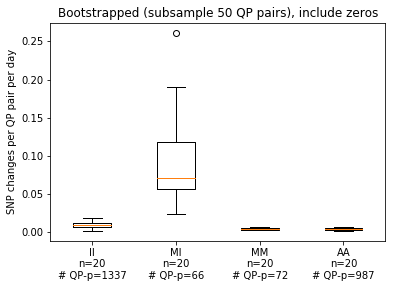

In [16]:
fig, ax = plt.subplots(figsize=(6,4))

tp_types = ['II', 'MI', 'MM', 'AA']
tp_type_labels = []

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_rates_by_tp_type[tp_type]), len(rates_by_tp_type[tp_type])))


ax.boxplot(bootstrapped_rates)
ax.set_xticklabels(tp_type_labels)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample 50 QP pairs), include zeros")

plt.show()

fig.savefig('%s/snp_change_rates_by_tp_type_bootstrap_with_zeros.pdf' % plot_dir, bbox_inches='tight')

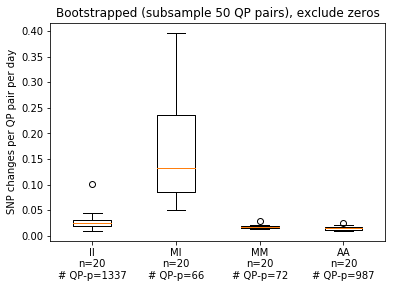

In [17]:
fig, ax = plt.subplots(figsize=(6,4))

tp_types = ['II', 'MI', 'MM', 'AA']
tp_type_labels = []

bootstrapped_rates = [bootstrapped_rates_by_tp_type_no_zeros[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_rates_by_tp_type[tp_type]), len(rates_by_tp_type[tp_type])))


ax.boxplot(bootstrapped_rates)
ax.set_xticklabels(tp_type_labels)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample 50 QP pairs), exclude zeros")

plt.show()

fig.savefig('%s/snp_change_rates_by_tp_type_bootstrap_no_zeros.pdf' % plot_dir, bbox_inches='tight')

In [58]:
# Look at infant only

count_time_tups_by_infant_tp_type = defaultdict(list)
replacement_time_tups_by_infant_tp_type = defaultdict(list)
infant_tp_type_dict = {'Day 0-3': (0, 3), 'Days 4-7': (4, 7), 'Week 1 - Month 1': (8,31), 'Month 1 - Month 4': (32,122), 'Month 1 - Year 1': (32, 365)}
infant_tp_type_cohort_comp = {tt: [] for tt in infant_tp_type_dict}

for s1, s2 in snp_change_counts:
    
    if s1 in olm_samples:
        continue
    
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type != 'II':
        continue
    
    day1 = mi_sample_day_dict[s1]
    day2 = mi_sample_day_dict[s2]
    
    for infant_tp_type in infant_tp_type_dict:
        start, end = infant_tp_type_dict[infant_tp_type]
        if day1 >= start and day2 <= end:
            days = np.abs(day1 - day2)
            for species in snp_change_counts[(s1, s2)]:
                num_sweeps = snp_change_counts[(s1, s2)][species]
                count_time_tups_by_infant_tp_type[infant_tp_type].append((num_sweeps, days))
                infant_tp_type_cohort_comp[infant_tp_type].append(sample_cohort_map[s1])

for s1, s2 in replacements:
    
    if s1 in olm_samples:
        continue
    
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type != 'II':
        continue
    
    day1 = mi_sample_day_dict[s1]
    day2 = mi_sample_day_dict[s2]
    
    for infant_tp_type in infant_tp_type_dict:
        start, end = infant_tp_type_dict[infant_tp_type]
        if day1 >= start and day2 <= end:
            days = np.abs(day1 - day2)
            for species in replacements[(s1, s2)]:
                num_snp_diffs = replacements[(s1, s2)][species]
                replacement_time_tups_by_infant_tp_type[infant_tp_type].append((num_snp_diffs, days))

In [23]:
for tp_type in count_time_tups_by_infant_tp_type:
    print(len(count_time_tups_by_infant_tp_type[tp_type]))

62
391
93
62
9


In [24]:
bootstrapped_rates_by_infant_tp_type = defaultdict(list)
bootstrapped_rates_by_infant_tp_type_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_infant_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_infant_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_infant_tp_type[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_infant_tp_type_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

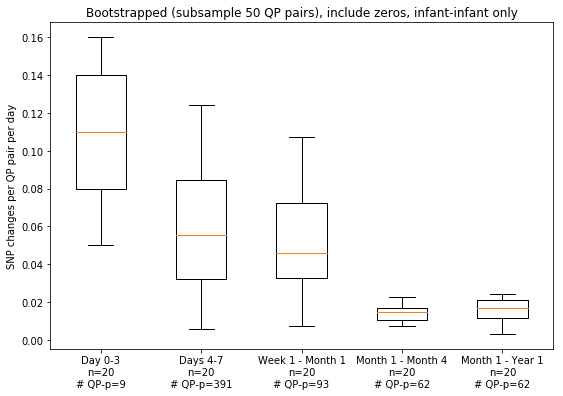

In [25]:
fig, ax = plt.subplots(figsize=(9,6))

tp_types = ['Day 0-3', 'Days 4-7', 'Week 1 - Month 1', 'Month 1 - Month 4', 'Month 1 - Year 1']
tp_type_labels = []

bootstrapped_rates = [bootstrapped_rates_by_infant_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_rates_by_infant_tp_type[tp_type]), len(count_time_tups_by_infant_tp_type[tp_type])))


ax.boxplot(bootstrapped_rates)
ax.set_xticklabels(tp_type_labels)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample 50 QP pairs), include zeros, infant-infant only")

plt.show()

fig.savefig('%s/snp_change_rates_by_infant_tp_type_bootstrap_with_zeros.pdf' % plot_dir, bbox_inches='tight')

Focusing on Yassour mothers

In [30]:
count_time_tups_by_mother_tp_type = defaultdict(list)

for s1, s2 in snp_change_counts:
    
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type != 'MM':
        continue
    
    day1 = mi_sample_day_dict[s1]
    day2 = mi_sample_day_dict[s2]
    days = np.abs(day1 - day2)
    
    for species in snp_change_counts[(s1, s2)]:
        num_sweeps = snp_change_counts[(s1, s2)][species]
        count_time_tups_by_mother_tp_type[(tpa, tpb)].append((num_sweeps, days))

In [31]:
for tp_type in count_time_tups_by_mother_tp_type:
    print(tp_type)
    print(len(count_time_tups_by_mother_tp_type[tp_type]))

('M1', 'M2')
41
('M3', 'M2')
16
('M1', 'M3')
15


In [32]:
bootstrapped_rates_by_mother_tp_type = defaultdict(list)
bootstrapped_rates_by_mother_tp_type_no_zeros = defaultdict(list)

num_bootstraps = 10
n = 50

for tp_type in count_time_tups_by_mother_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_mother_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_mother_tp_type[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_mother_tp_type_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

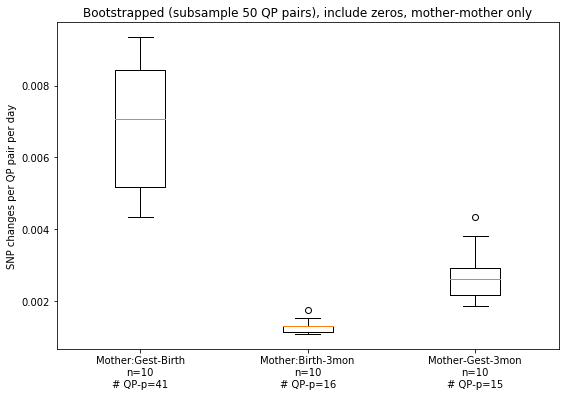

In [33]:
fig, ax = plt.subplots(figsize=(9,6))

tp_types = [('M1', 'M2'), ('M3', 'M2'), ('M1', 'M3')]
tp_type_dict = {('M1', 'M2'): 'Mother:Gest-Birth', ('M3', 'M2'): 'Mother:Birth-3mon', ('M1', 'M3'): 'Mother-Gest-3mon'}
tp_type_labels = []

bootstrapped_rates = [bootstrapped_rates_by_mother_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type_dict[tp_type], len(bootstrapped_rates_by_mother_tp_type[tp_type]), len(count_time_tups_by_mother_tp_type[tp_type])))


ax.boxplot(bootstrapped_rates)
ax.set_xticklabels(tp_type_labels)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample 50 QP pairs), include zeros, mother-mother only")

plt.show()

fig.savefig('%s/snp_change_rates_by_mother_tp_type_bootstrap_with_zeros.pdf' % plot_dir, bbox_inches='tight')

In [36]:
# Finally: combine infant breakdown with MI, MM, AA

count_time_tups_by_infant_tp_type = defaultdict(list)
infant_tp_type_dict = {'Day 0-Week 1': (0, 7), 'Week 1-Month 1': (7,31), 'Month 1-Month 4': (31,122), 'Month 1-Year 1': (31, 365)}
infant_tp_type_cohort_comp = {tt: [] for tt in infant_tp_type_dict}

for s1, s2 in snp_change_counts:
    
    if s1 in olm_samples:
        continue
    
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type != 'II':
        continue
    
    day1 = mi_sample_day_dict[s1]
    day2 = mi_sample_day_dict[s2]
    
    for infant_tp_type in infant_tp_type_dict:
        start, end = infant_tp_type_dict[infant_tp_type]
        if day1 >= start and day2 <= end:            
            days = np.abs(day1 - day2)
            for species in snp_change_counts[(s1, s2)]:
                num_sweeps = snp_change_counts[(s1, s2)][species]
                count_time_tups_by_infant_tp_type[infant_tp_type].append((num_sweeps, days))
                infant_tp_type_cohort_comp[infant_tp_type].append(sample_cohort_map[s1])

In [37]:
bootstrapped_rates_by_infant_tp_type = defaultdict(list)
bootstrapped_rates_by_infant_tp_type_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_infant_tp_type:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_infant_tp_type[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_infant_tp_type[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_infant_tp_type_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

In [23]:
from scipy import stats
tstatistic, pvalue = stats.ttest_ind([1,2,3],[1,2,3])

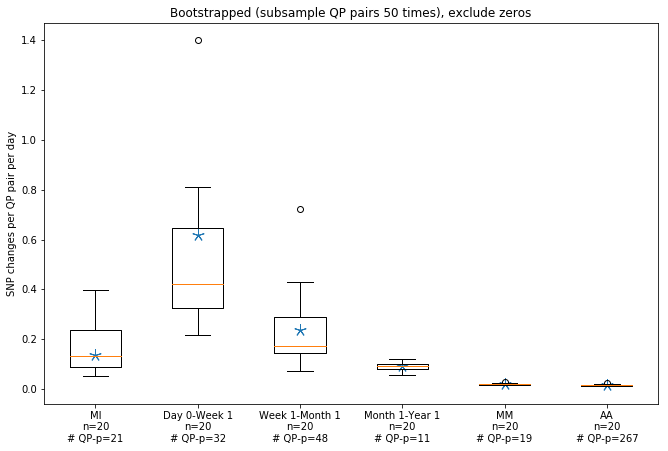

In [38]:
fig, ax = plt.subplots(figsize=(11,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_rates_by_infant_tp_type_no_zeros[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    snp_count, total_days = (0,0)
    nonzero_count = 0
    for count, days in count_time_tups_by_infant_tp_type[infant_tp_type]:
        # When excluding zeros
        if count > 0:
            snp_count += count
            total_days += days
            nonzero_count += 1
    annotations.append(float(snp_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, len(bootstrapped_rates_by_infant_tp_type_no_zeros[infant_tp_type]), nonzero_count))

bootstrapped_rates = [bootstrapped_rates_by_tp_type_no_zeros[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    snp_count, total_days = (0,0)
    nonzero_count = 0
    for count, days in count_time_tups_by_tp_type[tp_type]:
        # When excluding zeros
        if count > 0:
            snp_count += count
            total_days += days
            nonzero_count += 1    
    annotations.append(float(snp_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_rates_by_tp_type_no_zeros[tp_type]), nonzero_count))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample QP pairs 50 times), exclude zeros")

plt.show()

fig.savefig('%s/snp_change_rates_by_tp_type_overall_no_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

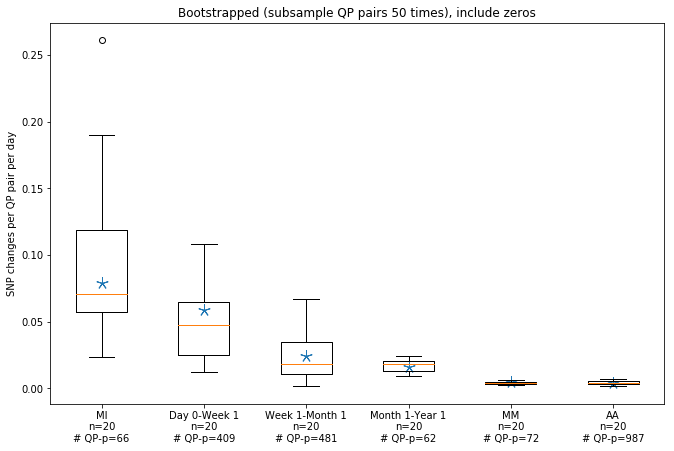

In [39]:
fig, ax = plt.subplots(figsize=(11,7))

tp_types = ['MI', 'MM', 'AA']
tp_type_labels = []
infant_tp_types = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
infant_tp_type_labels = []

annotations = []

bootstrapped_rates_infant = [bootstrapped_rates_by_infant_tp_type[infant_tp_type] for infant_tp_type in infant_tp_types]
for infant_tp_type in infant_tp_types:
    snp_count, total_days = (0,0)
    for count, days in count_time_tups_by_infant_tp_type[infant_tp_type]:
        snp_count += count
        total_days += days
    annotations.append(float(snp_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f %%' % (snp_count, total_days, (snp_count*100.0)/total_days))
    infant_tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (infant_tp_type, len(bootstrapped_rates_by_infant_tp_type[infant_tp_type]), len(count_time_tups_by_infant_tp_type[infant_tp_type])))

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    snp_count, total_days = (0,0)
    for count, days in count_time_tups_by_tp_type[tp_type]:
        snp_count += count
        total_days += days    
    annotations.append(float(snp_count)/total_days)
    # annotations.append('*\nSNP mods: %i\nTotal days: %i\nAvg rate: %.02f%%' % (snp_count, total_days, float(snp_count)/total_days))
    tp_type_labels.append('%s\nn=%i\n# QP-p=%i' % (tp_type, len(bootstrapped_rates_by_tp_type[tp_type]), len(count_time_tups_by_tp_type[tp_type])))

bootstrapped_rates_reordered = [bootstrapped_rates[0]] + bootstrapped_rates_infant + bootstrapped_rates[1:]
tp_type_labels_reordered = [tp_type_labels[0]] + infant_tp_type_labels + tp_type_labels[1:]
annotations_reordered = [annotations[3]] + annotations[0:3] + annotations[4:]

i = 0
for rates in bootstrapped_rates_reordered:
    # ax.text(i+0.7, max(rates) + 0.005, annotations_reordered[i], color='red')
    i += 1

ax.plot(np.arange(1, 1+len(annotations)), annotations_reordered, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates_reordered)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels_reordered)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

plt.show()

fig.savefig('%s/snp_change_rates_by_tp_type_overall_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [40]:
# Now plot proportion of zeros

prop_zeros_by_tp_type = defaultdict(list)
prop_zeros_by_infant_tp_type = defaultdict(list)

for tp_type in tp_types:
    zero_count = 0
    total_count = 0
    for count, days in count_time_tups_by_tp_type[tp_type]:
        if count == 0:
            zero_count += 1
        total_count += 1
    prop_zeros_by_tp_type[tp_type] = float(zero_count)/total_count

for infant_tp_type in infant_tp_types:
    zero_count = 0
    total_count = 0
    for count, days in count_time_tups_by_infant_tp_type[infant_tp_type]:
        if count == 0:
            zero_count += 1
        total_count += 1
    prop_zeros_by_infant_tp_type[infant_tp_type] = float(zero_count)/total_count

In [41]:
prop_zeros_by_tp_type

defaultdict(list,
            {'AA': 0.729483282674772,
             'MI': 0.6818181818181818,
             'MM': 0.7361111111111112})

In [42]:
prop_zeros_by_infant_tp_type

defaultdict(list,
            {'Day 0-Week 1': 0.921760391198044,
             'Month 1-Year 1': 0.8225806451612904,
             'Week 1-Month 1': 0.9002079002079002})

In [68]:
# Now plot replacement rates
# Firstly for each tp category, plot total # replacements / total time

replacements_by_tp_type = defaultdict(list)
replacements_by_infant_tp_type = defaultdict(list)

for tp_type in tp_types:
    replacement_count = 0
    total_days = 0
    for count, days in replacement_time_tups_by_tp_type[tp_type]:
        if count > 400: # Redundant check
            replacement_count += 1
        total_days += days
    replacements_by_tp_type[tp_type] = (replacement_count, total_days)

for infant_tp_type in infant_tp_types:
    replacement_count = 0
    total_days = 0
    for count, days in replacement_time_tups_by_infant_tp_type[infant_tp_type]:
        if count > 400: # Redundant check
            replacement_count += 1
            print(replacement_count)
        total_days += days
    replacements_by_infant_tp_type[infant_tp_type] = (replacement_count, total_days)

In [69]:
replacements_by_tp_type

defaultdict(list,
            {'AA': (26, 5307),
             'II': (137, 23151),
             'MI': (7, 14),
             'MM': (3, 368)})

MATCHING ATTEMPT

In [27]:
# Alternatively, perform matching

# Firstly, plot for each of 1 week, 1 month and 6 month
# durations the initial timepoint on x axis, and
# number of SNP changes on y-axis

# Arbitrarily set adults to be 35 years old -> 12765 days at second timepoint
adult_days = 12765

# To get sense of metadata, plot init days vs durations
durations_by_cohort = defaultdict(list)
init_days_by_cohort = defaultdict(list)

leeways_dict = {'1wk': 1, '1mon': 2, '6mon': 10} # Number of days away from focal duration
durations_dict = {'1wk': 7, '1mon': 30.5, '6mon': 183}
init_days_fixed_duration_dict = defaultdict(list)
snp_change_counts_fixed_duration_dict = defaultdict(list)

for s1, s2 in snp_change_counts:    
    num_sweeps = snp_change_counts[(s1, s2)]
    
    if s1 in olm_samples: # Ignore Olm
        continue
    
    # Form tp_type, days (duration between timepoints), cohort
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tp_type = tp_pair_to_tp_type(tp_pair)
    day1 = mi_sample_day_dict[s1] if tp_type not in ['AA'] else (adult_days + (sample_order_map[s1][1] * 30.5))
    days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
    cohort = sample_cohort_map[s1]
    
    # Store duration and init day info
    durations_by_cohort[cohort].append(days)
    init_days_by_cohort[cohort].append(day1)
    
    for duration_label in durations_dict:
        duration_days = durations_dict[duration_label]
        leeway = leeways_dict[duration_label]
        if days >= (duration_days-leeway) and days <= (duration_days+leeway):
            init_days_fixed_duration_dict[duration_label].append(day1)
            snp_change_counts_fixed_duration_dict[duration_label].append(num_sweeps)

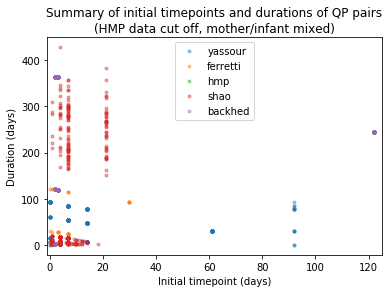

In [28]:
for cohort in durations_by_cohort:
    plt.plot(init_days_by_cohort[cohort], durations_by_cohort[cohort], '.', alpha=0.4, label=cohort)
plt.xlim(-1, 125)
# plt.ylim(5.5, 8.5)
plt.title('Summary of initial timepoints and durations of QP pairs\n(HMP data cut off, mother/infant mixed)')
plt.xlabel("Initial timepoint (days)")
plt.ylabel("Duration (days)")
plt.legend(loc='upper center')
plt.show()

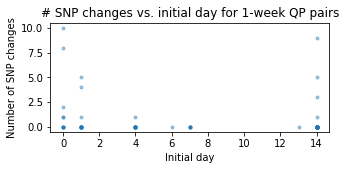

In [30]:
# Firstly, plot for each of 1 week, 1 month and 6 month
# durations the initial timepoint on x axis, and
# number of SNP changes on y-axis

duration_label = '1wk'
plt.figure(figsize=(5,2))
plt.plot(init_days_fixed_duration_dict[duration_label], snp_change_counts_fixed_duration_dict[duration_label], '.', alpha=0.4)
plt.title("# SNP changes vs. initial day for 1-week QP pairs")
plt.xlabel("Initial day")
plt.ylabel("Number of SNP changes")
plt.show()

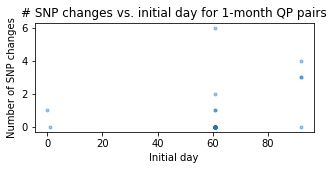

In [31]:
# Firstly, plot for each of 1 week, 1 month and 6 month
# durations the initial timepoint on x axis, and
# number of SNP changes on y-axis

duration_label = '1mon'
plt.figure(figsize=(5,2))
plt.plot(init_days_fixed_duration_dict[duration_label], snp_change_counts_fixed_duration_dict[duration_label], '.', alpha=0.4)
plt.title("# SNP changes vs. initial day for 1-month QP pairs")
plt.xlabel("Initial day")
plt.ylabel("Number of SNP changes")
plt.show()

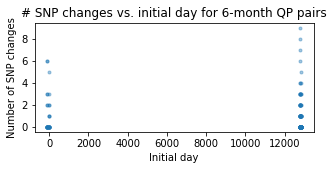

In [32]:
# Firstly, plot for each of 1 week, 1 month and 6 month
# durations the initial timepoint on x axis, and
# number of SNP changes on y-axis

duration_label = '6mon'
plt.figure(figsize=(5,2))
plt.plot(init_days_fixed_duration_dict[duration_label], snp_change_counts_fixed_duration_dict[duration_label], '.', alpha=0.4)
plt.title("# SNP changes vs. initial day for 6-month QP pairs")
plt.xlabel("Initial day")
plt.ylabel("Number of SNP changes")
plt.show()

In [33]:
# Alternatively, perform matching

# Can now try to make bootstrapped boxplots for each
# duration category; start with 1 week

count_time_tups_by_tp_type_1wk = defaultdict(list)
custom_tp_type_dict_1wk = {'Mom-7d': -1, '0-7d': 0, '1wk-2wk': 7, '2wk-3wk': 14, '3wk-1m': 21}
custom_tp_type_1wk_ordered = ['Mom-7d','0-7d','1wk-2wk','2wk-3wk','3wk-1m']

for s1, s2 in snp_change_counts:    
    num_sweeps = snp_change_counts[(s1, s2)]
    
    if s1 in olm_samples: # Ignore Olm
        continue
    
    # Form tp_type, days (duration between timepoints), cohort
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tp_type = tp_pair_to_tp_type(tp_pair)
    day1 = mi_sample_day_dict[s1] if tp_type not in ['AA'] else (adult_days + (sample_order_map[s1][1] * 30.5))
    days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
    cohort = sample_cohort_map[s1]
    
    # 1 week
    if days >= 6 and days <= 8:
        if tp_type == 'MI' and s1 in mother_samples and day1 == 0:
            count_time_tups_by_tp_type_1wk['Mom-7d'].append((num_sweeps, days))
        for custom_tp_type in custom_tp_type_dict_1wk:
            cur_day1 = custom_tp_type_dict_1wk[custom_tp_type]
            if day1 >= cur_day1 and day1 <= (cur_day1+6.99):
                count_time_tups_by_tp_type_1wk[custom_tp_type].append((num_sweeps, days))

In [34]:
bootstrapped_rates_by_tp_type_1wk = defaultdict(list)
bootstrapped_rates_by_tp_type_1wk_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_tp_type_1wk:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_tp_type_1wk[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type_1wk[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_tp_type_1wk_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

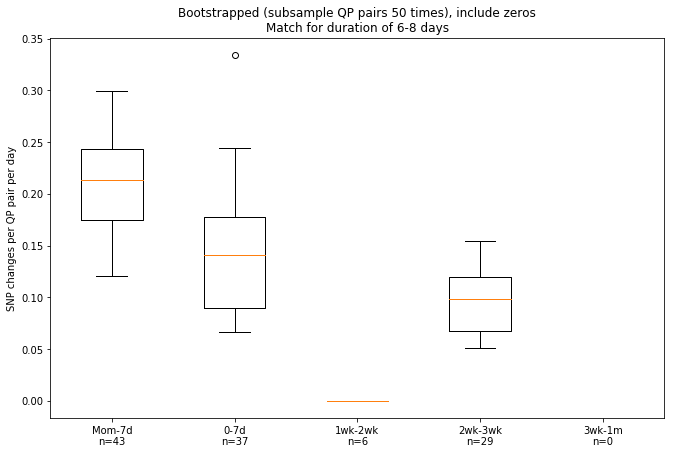

In [39]:
fig, ax = plt.subplots(figsize=(11,7))

bootstrapped_rates_by_tp_type_1wk_ordered = []
labels = []

for ctt in custom_tp_type_1wk_ordered:
    bootstrapped_rates_by_tp_type_1wk_ordered.append(bootstrapped_rates_by_tp_type_1wk[ctt])
    labels.append(ctt + '\nn=%i' % (len(count_time_tups_by_tp_type_1wk[ctt])))

ax.boxplot(bootstrapped_rates_by_tp_type_1wk_ordered)
ax.set_xticklabels(labels)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros\nMatch for duration of 6-8 days")

plt.show()

# fig.savefig('%s/snp_change_rates_by_tp_type_overall_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [40]:
# Alternatively, perform matching

# Can now try to make bootstrapped boxplots for each
# duration category; now do 1 month

count_time_tups_by_tp_type_1mon = defaultdict(list)
custom_tp_type_dict_1mon = {'Mom-1m': 0,'0d-1m': 0, '1m-2m': 30.5, '2m-3m': 61, '3m-4m': 91.5}
custom_tp_type_1mon_ordered = ['Mom-1m','0d-1m','1m-2m','2m-3m','3m-4m']

for s1, s2 in snp_change_counts:    
    num_sweeps = snp_change_counts[(s1, s2)]
    
    if s1 in olm_samples: # Ignore Olm
        continue
    
    # Form tp_type, days (duration between timepoints), cohort
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tp_type = tp_pair_to_tp_type(tp_pair)
    day1 = mi_sample_day_dict[s1] if tp_type not in ['AA'] else (adult_days + (sample_order_map[s1][1] * 30.5))
    days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
    cohort = sample_cohort_map[s1]
    
    # 1 month
    if days >= 28 and days <= 32:
        if tp_type == 'MI' and s1 in mother_samples and day1 == 0:
            count_time_tups_by_tp_type_1mon['Mom-1m'].append((num_sweeps, days))
        for custom_tp_type in custom_tp_type_dict_1mon:
            cur_day1 = custom_tp_type_dict_1mon[custom_tp_type]
            if day1 >= cur_day1 and day1 <= (cur_day1+30.499):
                count_time_tups_by_tp_type_1mon[custom_tp_type].append((num_sweeps, days))

In [41]:
bootstrapped_rates_by_tp_type_1mon = defaultdict(list)
bootstrapped_rates_by_tp_type_1mon_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_tp_type_1mon:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_tp_type_1mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type_1mon[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_tp_type_1mon_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

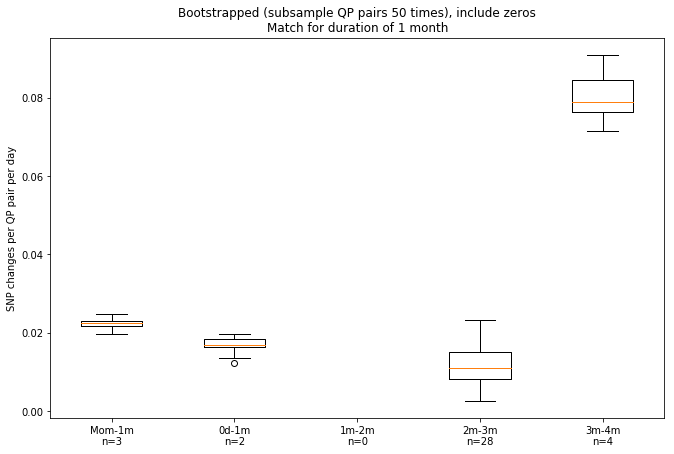

In [42]:
fig, ax = plt.subplots(figsize=(11,7))

bootstrapped_rates_by_tp_type_1mon_ordered = []
labels = []

for ctt in custom_tp_type_1mon_ordered:
    bootstrapped_rates_by_tp_type_1mon_ordered.append(bootstrapped_rates_by_tp_type_1mon[ctt])
    labels.append(ctt + '\nn=%i' % (len(count_time_tups_by_tp_type_1mon[ctt])))

ax.boxplot(bootstrapped_rates_by_tp_type_1mon_ordered)
ax.set_xticklabels(labels)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros\nMatch for duration of 1 month")

plt.show()

# fig.savefig('%s/snp_change_rates_by_tp_type_overall_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [43]:
# Alternatively, perform matching

# Can now try to make bootstrapped boxplots for each
# duration category; now do 6 months

count_time_tups_by_tp_type_6mon = {'infant': [], 'adult': []}

for s1, s2 in snp_change_counts:    
    num_sweeps = snp_change_counts[(s1, s2)]
    
    if s1 in olm_samples: # Ignore Olm
        continue
    
    # Form tp_type, days (duration between timepoints), cohort
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tp_type = tp_pair_to_tp_type(tp_pair)
    day1 = mi_sample_day_dict[s1] if tp_type not in ['AA'] else (adult_days + (sample_order_map[s1][1] * 30.5))
    days = adult_tp_pair_to_days(tp_pair) if tp_type in ['AA'] else sample_pair_to_days(s1, s2)
    cohort = sample_cohort_map[s1]
    
    # 6 months +/- 8 days
    if days >= 175 and days <= 191:
        if tp_type == 'II':
            count_time_tups_by_tp_type_6mon['infant'].append((num_sweeps, days))
        elif tp_type == 'AA':
            count_time_tups_by_tp_type_6mon['adult'].append((num_sweeps, days))

In [44]:
bootstrapped_rates_by_tp_type_6mon = defaultdict(list)
bootstrapped_rates_by_tp_type_6mon_no_zeros = defaultdict(list)

num_bootstraps = 20
n = 50

for tp_type in count_time_tups_by_tp_type_6mon:
    for _ in np.arange(num_bootstraps):
        all_tups = count_time_tups_by_tp_type_6mon[tp_type]
        bootstrap = [random.choice(all_tups) for i in np.arange(n)]
        total_sweeps = 0
        total_days = 0
        total_days_no_zeros = 0
        for num_sweeps, days in bootstrap:
            total_sweeps += num_sweeps
            total_days += days
            if num_sweeps > 0:
                total_days_no_zeros += days
        bootstrapped_rates_by_tp_type_6mon[tp_type].append(float(total_sweeps)/total_days)
        try:
            bootstrapped_rates_by_tp_type_6mon_no_zeros[tp_type].append(float(total_sweeps)/total_days_no_zeros)
        except:
            continue

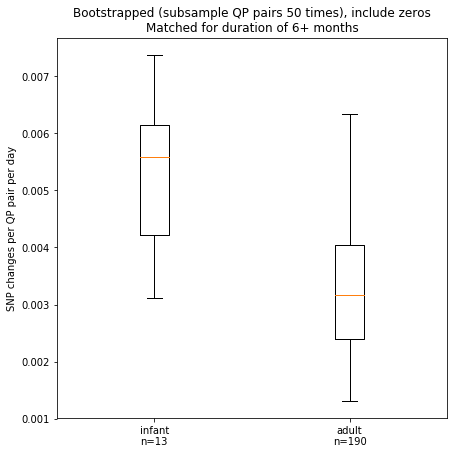

In [50]:
fig, ax = plt.subplots(figsize=(7,7))

bootstrapped_rates_by_tp_type_6mon_ordered = []
labels = []

for ctt in ['infant', 'adult']:
    bootstrapped_rates_by_tp_type_6mon_ordered.append(bootstrapped_rates_by_tp_type_6mon[ctt])
    labels.append(ctt + '\nn=%i' % (len(count_time_tups_by_tp_type_6mon[ctt])))

ax.boxplot(bootstrapped_rates_by_tp_type_6mon_ordered)
ax.set_xticklabels(labels)
ax.set_ylabel("SNP changes per QP pair per day")
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros\nMatched for duration of 6+ months")

plt.show()

# fig.savefig('%s/snp_change_rates_by_tp_type_overall_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [26]:
num_cats = len(bootstrapped_rates_reordered)

t_stat_matrix = np.zeros(shape=(num_cats, num_cats))
pvalue_matrix = np.zeros(shape=(num_cats, num_cats))

for i in range(0, num_cats):
    for j in range(i+1, num_cats):
        rates1 = bootstrapped_rates_reordered[i]
        rates2 = bootstrapped_rates_reordered[j]
        t_stat, pvalue = stats.ttest_ind(rates1, rates2, equal_var=False)
        t_stat_matrix[i][j] = t_stat
        pvalue_matrix[i][j] = pvalue

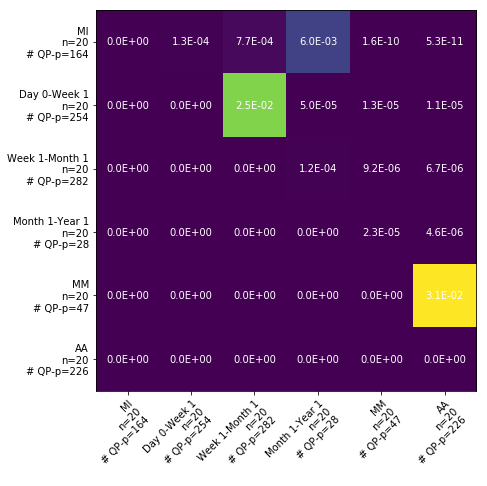

In [27]:
from decimal import Decimal

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(pvalue_matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(num_cats))
ax.set_yticks(np.arange(num_cats))
# ... and label them with the respective list entries
ax.set_xticklabels(tp_type_labels_reordered)
ax.set_yticklabels(tp_type_labels_reordered)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(num_cats):
    for j in range(num_cats):
        text = ax.text(j, i, '%.1E' % Decimal(pvalue_matrix[i, j]),
                       ha="center", va="center", color="w")

plt.show()

In [105]:
# Now try scatterplot of individual rates vs first timepoint

# Arbitrarily set adults to be 35 years old -> 12765 days at second timepoint
adult_days = 12765

init_days = []
amount_time = []
age_classes = []
snp_mod_rates = []
num_snp_changes = []

init_days_by_age_class = defaultdict(list)
amount_time_by_age_class = defaultdict(list)
snp_mod_rates_by_age_class = defaultdict(list)
num_snp_changes_by_age_class = defaultdict(list)

infant_tp_type_dict = {'Day 0-Week 1': (0, 7), 'Week 1 - Month 1': (7,31), 'Month 1 - Year 1': (31, 365)}

for s1, s2 in snp_change_counts:            
    
    if s1 in olm_samples:
        continue
    
    tp_pair = su.sample_pair_to_tp_pair(s1, s2, sample_order_map, hmp_samples, mother_samples)
    tpa, tpb = tp_pair
    tp_type = tpa[0] + tpb[0]
    if tp_type == 'IM':
        tp_type = 'MI'
    
    # Condition MI on comparing to infants in first week
    if tp_type == 'MI':
        if s1 in mother_samples and abs(mi_sample_day_dict[s1]) > 7:
            continue
        if s2 in mother_samples and abs(mi_sample_day_dict[s2]) > 7:
            continue
        if s2 in infant_samples and mi_sample_day_dict[s2] > 7:
            # print(mi_sample_day_dict[s2])
            continue
        if s1 in infant_samples and mi_sample_day_dict[s1] > 7:
            # print(mi_sample_day_dict[s1])
            continue
    
    age_class = tp_type
    if tp_type == 'II':
        day1 = mi_sample_day_dict[s1]
        day2 = mi_sample_day_dict[s2]

        for infant_tp_type in infant_tp_type_dict:
            start, end = infant_tp_type_dict[infant_tp_type]
            if day1 >= start and day2 <= end:
                age_class = infant_tp_type
        
        if age_class == 'II': # No corresponding specific tp type
            continue
    
    num_sweeps = snp_change_counts[(s1, s2)]

    if tp_type in ['AA']:
        days = adult_tp_pair_to_days(tp_pair)
        adult_order = sample_order_map[s1][1]
        init_day = adult_days + (adult_order * 30.5)
    else:
        days = sample_pair_to_days(s1, s2)
        init_day = mi_sample_day_dict[s1]
    
    if days == 0:
        print(tp_pair, mi_sample_day_dict[s1], mi_sample_day_dict[s2])
        if mi_sample_day_dict[s1] == 0:
            days = 1
        else:
            continue
    
    init_days.append(init_day)
    init_days_by_age_class[age_class].append(init_day)
    
    # if age_class == 'MI':
        # print("Mother infant: %i" % days)
    
    amount_time.append(days)
    amount_time_by_age_class[age_class].append(days)
    
    age_classes.append(age_class)
    
    snp_mod_rates.append(float(num_sweeps)/days)
    snp_mod_rates_by_age_class[age_class].append(float(num_sweeps)/days)
    
    num_snp_changes.append(num_sweeps)
    num_snp_changes_by_age_class[age_class].append(num_sweeps)

(frozenset(['I1', 'M2']), 0, 0)
(frozenset(['I1', 'M2']), 0, 0)


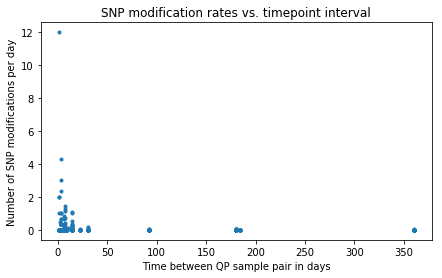

In [107]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(amount_time, snp_mod_rates, '.')

ax.set_xlabel("Time between QP sample pair in days")
ax.set_ylabel("Number of SNP modifications per day")
ax.set_title("SNP modification rates vs. timepoint interval")

plt.show()

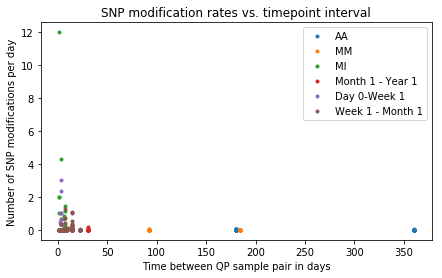

In [108]:
fig, ax = plt.subplots(figsize=(7,4))

for age_class in ['AA', 'MM', 'MI', 'Month 1 - Year 1', 'Day 0-Week 1', 'Week 1 - Month 1']:
    ax.plot(amount_time_by_age_class[age_class], snp_mod_rates_by_age_class[age_class], '.', label=age_class)

ax.legend()
ax.set_xlabel("Time between QP sample pair in days")
ax.set_ylabel("Number of SNP modifications per day")
ax.set_title("SNP modification rates vs. timepoint interval")

plt.show()

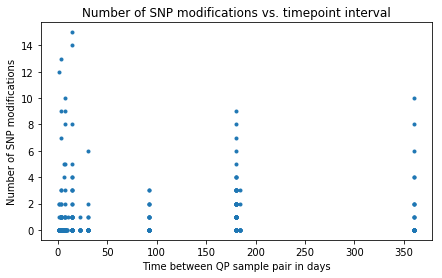

In [109]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(amount_time, num_snp_changes, '.')

ax.set_xlabel("Time between QP sample pair in days")
ax.set_ylabel("Number of SNP modifications")
ax.set_title("Number of SNP modifications vs. timepoint interval")

plt.show()

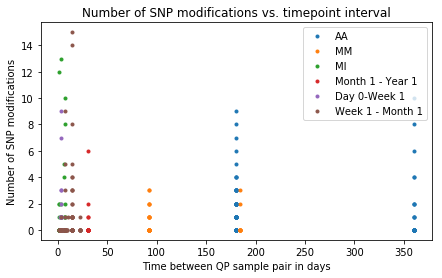

In [110]:
fig, ax = plt.subplots(figsize=(7,4))

for age_class in ['AA', 'MM', 'MI', 'Month 1 - Year 1', 'Day 0-Week 1', 'Week 1 - Month 1']:
    ax.plot(amount_time_by_age_class[age_class], num_snp_changes_by_age_class[age_class], '.', label=age_class)

ax.legend()
ax.set_xlabel("Time between QP sample pair in days")
ax.set_ylabel("Number of SNP modifications")
ax.set_title("Number of SNP modifications vs. timepoint interval")

plt.show()

In [111]:
init_days_exclude_neg = []
snp_mod_rates_exclude_neg = []

for (init_day, snp_mod_rate) in zip(init_days, snp_mod_rates):
    if init_day >= 0:
        init_days_exclude_neg.append(init_day)
        snp_mod_rates_exclude_neg.append(snp_mod_rate)

# Add pseudocount to both
pseudocount = (1e-10)
init_days_exclude_neg = np.array(init_days_exclude_neg) + pseudocount
snp_mod_rates_exclude_neg = np.array(snp_mod_rates_exclude_neg) + pseudocount

In [112]:
init_days_by_age_class_exclude_neg = defaultdict(list)
snp_mod_rates_by_age_class_exclude_neg = defaultdict(list)
num_snp_changes_by_age_class_exclude_neg = defaultdict(list)

for age_class in snp_mod_rates_by_age_class:    
    for i in range(len(init_days_by_age_class[age_class])):
        init_day = init_days_by_age_class[age_class][i]
        snp_mod_rate = snp_mod_rates_by_age_class[age_class][i]
        num_snp_changes = num_snp_changes_by_age_class[age_class][i]
        if init_day >= 0:
            init_days_by_age_class_exclude_neg[age_class].append(init_day)
            snp_mod_rates_by_age_class_exclude_neg[age_class].append(snp_mod_rate)
            num_snp_changes_by_age_class_exclude_neg[age_class].append(num_snp_changes)
    
# Add pseudocounts
pseudocount = (1e-3)
for age_class in snp_mod_rates_by_age_class:
    init_days_by_age_class_exclude_neg[age_class] = np.array(init_days_by_age_class_exclude_neg[age_class]) + pseudocount
    snp_mod_rates_by_age_class_exclude_neg[age_class] = np.array(snp_mod_rates_by_age_class_exclude_neg[age_class]) + pseudocount

In [113]:
init_days_by_age_class_exclude_neg.keys()

['AA', 'Month 1 - Year 1', 'Day 0-Week 1', 'Week 1 - Month 1', 'MI', 'MM']

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:16: RankWarning: Polyfit may be poorly conditioned
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:16: RankWarning: Polyfit may be poorly conditioned


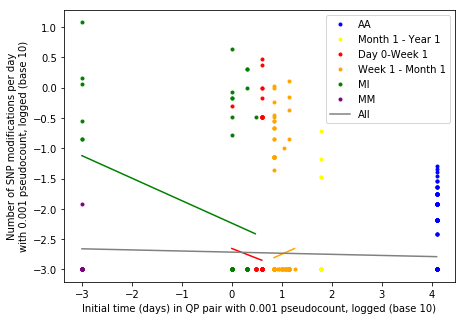

In [115]:
fig, ax = plt.subplots(figsize=(7,5))

colors = {'Day 0-Week 1': 'red', 'Week 1 - Month 1': 'orange', 'Month 1 - Year 1': 'yellow', 'MI': 'green', 'AA': 'blue', 'MM': 'purple'}

all_init_days_logged = []
all_snp_mod_rates_logged = []

for age_class in init_days_by_age_class_exclude_neg:
    color = colors[age_class]
    
    init_days_logged = np.log10(init_days_by_age_class_exclude_neg[age_class])
    snp_mod_rates_logged = np.log10(snp_mod_rates_by_age_class_exclude_neg[age_class])
    
    ax.plot(init_days_logged, snp_mod_rates_logged, '.', label=age_class, color=color)
    
    m, b = np.polyfit(init_days_logged, snp_mod_rates_logged, 1)
    x = np.arange(min(init_days_logged), max(init_days_logged), 0.01)
    ax.plot(x, m*x + b, color=color)
    
    all_init_days_logged += list(init_days_logged)
    all_snp_mod_rates_logged += list(snp_mod_rates_logged)

m, b = np.polyfit(all_init_days_logged, all_snp_mod_rates_logged, 1)
x = np.arange(min(all_init_days_logged), max(all_init_days_logged), 0.01)
ax.plot(x, m*x + b, color='gray', label="All")

ax.legend()
ax.set_ylabel("Number of SNP modifications per day\nwith 0.001 pseudocount, logged (base 10)")
ax.set_xlabel('Initial time (days) in QP pair with 0.001 pseudocount, logged (base 10)')

plt.show()

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:17: RankWarning: Polyfit may be poorly conditioned


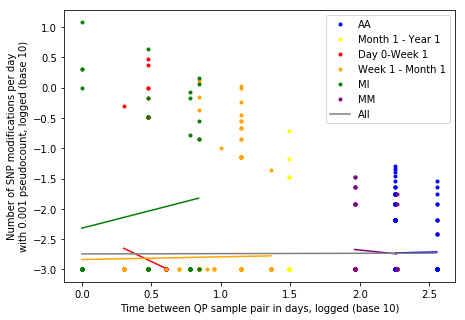

In [117]:
# Now try the same but with time difference on x axis
fig, ax = plt.subplots(figsize=(7,5))

colors = {'Day 0-Week 1': 'red', 'Week 1 - Month 1': 'orange', 'Month 1 - Year 1': 'yellow', 'MI': 'green', 'AA': 'blue', 'MM': 'purple'}

all_amount_time_logged = []
all_snp_mod_rates_logged = []

for tp_type in snp_mod_rates_by_age_class:
    color = colors[tp_type]
    
    amount_time_logged = np.log10(amount_time_by_age_class[tp_type])
    snp_mod_rates_logged = np.log10(np.array(snp_mod_rates_by_age_class[tp_type]) + pseudocount)
    
    ax.plot(amount_time_logged, snp_mod_rates_logged, '.', label=tp_type, color=color)
    
    m, b = np.polyfit(amount_time_logged, snp_mod_rates_logged, 1)
    x = np.arange(min(amount_time_logged), max(amount_time_logged), 0.01)
    ax.plot(x, m*x + b, color=color)
    
    all_amount_time_logged += list(amount_time_logged)
    all_snp_mod_rates_logged += list(snp_mod_rates_logged)

m, b = np.polyfit(all_amount_time_logged, all_snp_mod_rates_logged, 1)
x = np.arange(min(all_amount_time_logged), max(all_amount_time_logged), 0.01)
ax.plot(x, m*x + b, color='gray', label="All")

ax.legend()
ax.set_ylabel("Number of SNP modifications per day\nwith 0.001 pseudocount, logged (base 10)")
ax.set_xlabel('Time between QP sample pair in days, logged (base 10)')

plt.show()

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:18: RankWarning: Polyfit may be poorly conditioned


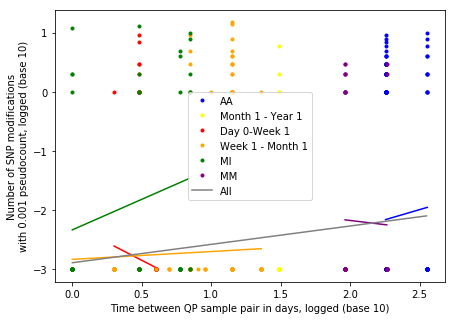

In [118]:
# Now try the same but with time difference on x axis
fig, ax = plt.subplots(figsize=(7,5))

colors = {'Day 0-Week 1': 'red', 'Week 1 - Month 1': 'orange', 'Month 1 - Year 1': 'yellow', 'MI': 'green', 'AA': 'blue', 'MM': 'purple'}
pseudocount = 0.001

all_amount_time_logged = []
all_num_snp_changes_logged = []

for tp_type in snp_mod_rates_by_age_class:
    color = colors[tp_type]
    
    amount_time_logged = np.log10(amount_time_by_age_class[tp_type])
    num_snp_changes_logged = np.log10(np.array(num_snp_changes_by_age_class[tp_type]) + pseudocount)
    
    ax.plot(amount_time_logged, num_snp_changes_logged, '.', label=tp_type, color=color)
    
    m, b = np.polyfit(amount_time_logged, num_snp_changes_logged, 1)
    x = np.arange(min(amount_time_logged), max(amount_time_logged), 0.01)
    ax.plot(x, m*x + b, color=color)
    
    all_amount_time_logged += list(amount_time_logged)
    all_num_snp_changes_logged += list(num_snp_changes_logged)

m, b = np.polyfit(all_amount_time_logged, all_num_snp_changes_logged, 1)
x = np.arange(min(all_amount_time_logged), max(all_amount_time_logged), 0.01)
ax.plot(x, m*x + b, color='gray', label="All")

ax.legend()
ax.set_ylabel("Number of SNP modifications\nwith 0.001 pseudocount, logged (base 10)")
ax.set_xlabel('Time between QP sample pair in days, logged (base 10)')

plt.show()

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:13: RankWarning: Polyfit may be poorly conditioned


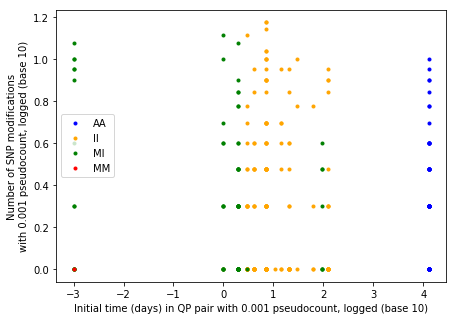

In [95]:
fig, ax = plt.subplots(figsize=(7,5))

colors = {'II': 'orange', 'MI': 'green', 'AA': 'blue', 'MM': 'red'}

for tp_type in init_days_by_age_class_exclude_neg:
    color = colors[tp_type]
    
    init_days_logged = np.log10(init_days_by_age_class_exclude_neg[tp_type])
    num_snp_changes_logged = np.log10(num_snp_changes_by_age_class_exclude_neg[tp_type])
    
    ax.plot(init_days_logged, num_snp_changes_logged, '.', label=tp_type, color=color)
    
    m, b = np.polyfit(init_days_logged, num_snp_changes_logged, 1)
    x = np.arange(min(init_days_logged), max(init_days_logged), 0.01)
    ax.plot(x, m*x + b, color=color)

ax.legend()
ax.set_ylabel("Number of SNP modifications\nwith 0.001 pseudocount, logged (base 10)")
ax.set_xlabel('Initial time (days) in QP pair with 0.001 pseudocount, logged (base 10)')

plt.show()

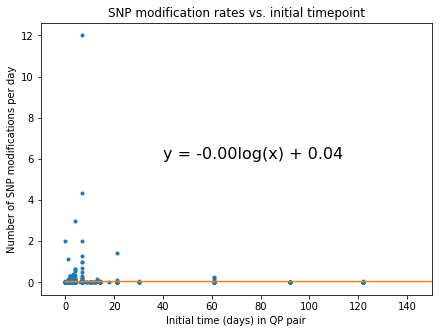

In [100]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(init_days_exclude_neg, snp_mod_rates_exclude_neg, '.')

x = np.arange(min(init_days_exclude_neg), max(init_days_exclude_neg), 0.001)
m, b = np.polyfit(np.log(init_days_exclude_neg), snp_mod_rates_exclude_neg, 1)
ax.plot(x, m*np.log(x) + b)

ax.text(40, 6, 'y = %.02flog(x) + %.02f' % (m, b), fontsize=16)
ax.set_xlim((-10, 150))
ax.set_xlabel("Initial time (days) in QP pair")
ax.set_ylabel("Number of SNP modifications per day")
ax.set_title("SNP modification rates vs. initial timepoint")

plt.show()

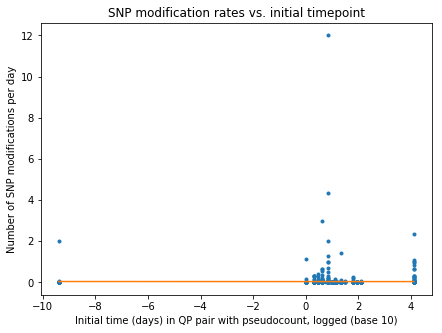

In [122]:
fig, ax = plt.subplots(figsize=(7,5))

init_days_logged = np.log10(init_days_exclude_neg)
ax.plot(init_days_logged, snp_mod_rates_exclude_neg, '.')

x = np.arange(min(init_days_logged), max(init_days_logged), 0.01)
m, b = np.polyfit(init_days_logged, snp_mod_rates_exclude_neg, 1)
ax.plot(x, m*x + b)

ax.set_xlabel("Initial time (days) in QP pair with pseudocount, logged (base 10)")
ax.set_ylabel("Number of SNP modifications per day")
ax.set_title("SNP modification rates vs. initial timepoint")

plt.show()

In [118]:
x = np.exp(np.logspace(min(init_days_logged), max(init_days_logged)))
x

/u/local/apps/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000001e+000, 1.00000001e+000, 1.00000002e+000, 1.00000003e+000,
       1.00000006e+000, 1.00000012e+000, 1.00000023e+000, 1.00000043e+000,
       1.00000081e+000, 1.00000153e+000, 1.00000289e+000, 1.00000545e+000,
       1.00001028e+000, 1.00001940e+000, 1.00003660e+000, 1.00006904e+000,
       1.00013024e+000, 1.00024570e+000, 1.00046355e+000, 1.00087461e+000,
       1.00165051e+000, 1.00311579e+000, 1.00588573e+000, 1.01113179e+000,
       1.02110254e+000, 1.04017979e+000, 1.07714278e+000, 1.15048308e+000,
       1.30269979e+000, 1.64680478e+000, 2.56255518e+000, 5.90092768e+000,
       2.84618007e+001, 5.53754671e+002, 1.49619440e+005, 5.78210852e+009,
       2.60122790e+018, 5.47460490e+034, 3.39120222e+065, 4.13349787e+123,
       1.54722993e+233,             inf,             inf,             inf,
                   inf,             inf])

In [116]:
x

array([4.00000000e-10, 7.54559136e-10, 1.42339873e-09, 2.68509628e-09,
       5.06515983e-09, 9.55490657e-09, 1.80243551e-08, 3.40011046e-08,
       6.41396103e-08, 1.20992822e-07, 2.28240599e-07, 4.30552573e-07,
       8.12193444e-07, 1.53211996e-06, 2.89018778e-06, 5.45204400e-06,
       1.02847240e-05, 1.94010812e-05, 3.65981577e-05, 6.90386856e-05,
       1.30234428e-04, 2.45673943e-04, 4.63438795e-04, 8.74229943e-04,
       1.64914548e-03, 3.11094447e-03, 5.86847893e-03, 1.10702860e-02,
       2.08829636e-02, 3.93935774e-02, 7.43119593e-02, 1.40181920e-01,
       2.64438871e-01, 4.98836915e-01, 9.41004879e-01, 1.77510957e+00,
       3.34856286e+00, 6.31672176e+00, 1.19158503e+01, 2.24780342e+01,
       4.24025153e+01, 7.99880133e+01, 1.50889216e+02, 2.84637090e+02,
       5.36938793e+02, 1.01288018e+03, 1.91069498e+03, 3.60433089e+03,
       6.79920201e+03, 1.28260000e+04])

In [87]:
init_days_exclude_zeros = []
snp_mod_rates_exclude_zeros = []

for (init_day, snp_mod_rate) in zip(init_days, snp_mod_rates):
    if snp_mod_rate > 0 and init_day >= 0:
        init_day = 0.001 if init_day == 0 else init_day
        init_days_exclude_zeros.append(init_day)
        snp_mod_rates_exclude_zeros.append(snp_mod_rate)

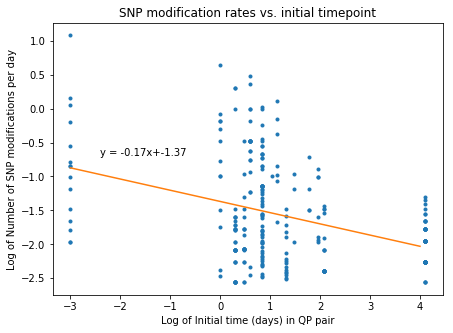

In [100]:
fig, ax = plt.subplots(figsize=(7,5))

init_days_logged = np.log10(init_days_exclude_zeros)
snp_mod_rates_logged = np.log10(snp_mod_rates_exclude_zeros)

m, b = np.polyfit(init_days_logged, snp_mod_rates_logged, 1)
x = np.arange(min(init_days_logged), max(init_days_logged))

ax.plot(init_days_logged, snp_mod_rates_logged, '.')
ax.plot(x, m*x + b)

ax.text(-2.4, -0.7, "y = %.02fx+%.02f" % (m, b))
ax.set_xlabel("Log of Initial time (days) in QP pair")
ax.set_ylabel("Log of Number of SNP modifications per day")
ax.set_title("SNP modification rates vs. initial timepoint")

plt.show()